In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Загрузка данных из Excel-файла и первичный анализ
target_xlsx ='https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
df = pd.read_excel(target_xlsx)

In [11]:
display(df.head())

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [12]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [14]:
target = 'SI'
cols_to_drop= ['IC50, mM', 'CC50, mM', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

Исходное количество записей: 1001


In [15]:
mean_SI = df[target].mean()
std_SI = df[target].std()
lower_bound = mean_SI - 2 * std_SI
upper_bound = mean_SI + 2 * std_SI

df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].copy()

filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")


Количество записей после удаления выбросов: 993
Удалено записей: 8


In [16]:
# Создание целевой переменной
df['SI_Median'] = (df[target] > df[target].median()).astype(int)
target = 'SI_Median'

In [17]:
RANDOM_STATE = 123

In [18]:
# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]


In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

In [20]:
df_regress = X.copy()

# Добавление новых признаков молярный
df_regress['MolLogP_MolWt'] = df_regress['MolLogP'] * df_regress['MolWt']

In [21]:
# Полиномиальные признаки
existing_poly_cols = [col for col in ['MolLogP', 'MolWt'] if col in df_regress.columns]

In [22]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_regress[existing_poly_cols])
poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_regress.index)
for col in new_poly_df.columns:
   if col not in df_regress.columns:
       df_regress[col] = new_poly_df[col]

In [23]:
df_regress['MolLogP_gt_3'] = (df_regress['MolLogP'] > 3).astype(int)

In [24]:
imputer = SimpleImputer(strategy='median')
df_regress = pd.DataFrame(imputer.fit_transform(df_regress), columns=df_regress.columns)

In [25]:
print("Получили новые признаки:", [col for col in df_regress.columns if col not in df.columns])

Получили новые признаки: ['MolLogP_MolWt', 'MolLogP^2', 'MolLogP MolWt', 'MolWt^2', 'MolLogP_gt_3']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [27]:
results = []

**Logistic Regression**

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)

In [29]:
#Обучение и прогноз модели Logistic Regression

name = 'Logistic Regression'
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

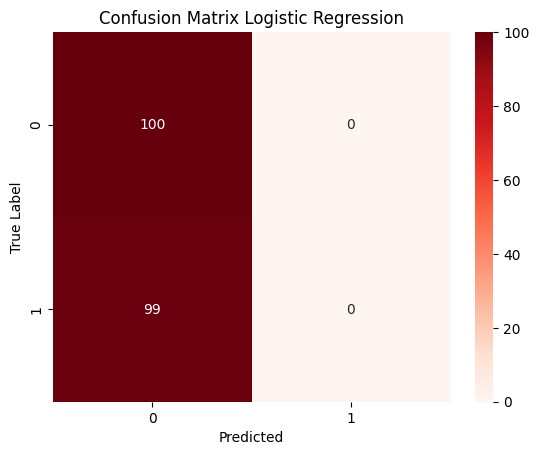

In [30]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [31]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Model': 'Logistic Regression',
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'Accuracy': 0.5025125628140703,
 'ROC-AUC': 0.5768686868686869}

**KNN**

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
#Обучение и прогноз модели KNN

name = 'KNN'
model =  KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0])

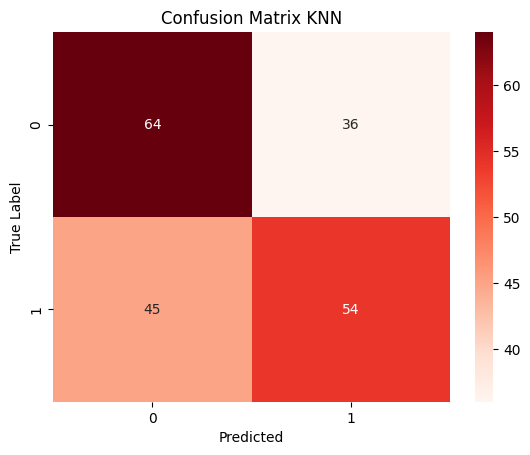

In [34]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [35]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'KNN',
 'Precision': 0.6,
 'Recall': 0.5454545454545454,
 'F1 Score': 0.5714285714285714,
 'Accuracy': 0.592964824120603,
 'ROC-AUC': 0.6214141414141414}

**Random Forest**

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
#Обучение и прогноз модели Random Forest

name = 'Random Forest'
model =  RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0])

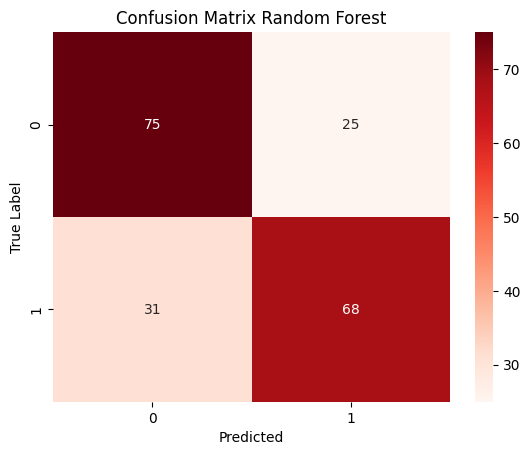

In [38]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [39]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Random Forest',
 'Precision': 0.7311827956989247,
 'Recall': 0.6868686868686869,
 'F1 Score': 0.7083333333333334,
 'Accuracy': 0.7185929648241206,
 'ROC-AUC': 0.7590404040404041}

**Gradient Boosting**

In [40]:
from sklearn.ensemble import  GradientBoostingClassifier

In [41]:
#Обучение и прогноз модели Gradient Boosting

name = 'Gradient Boosting'
model =  GradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0])

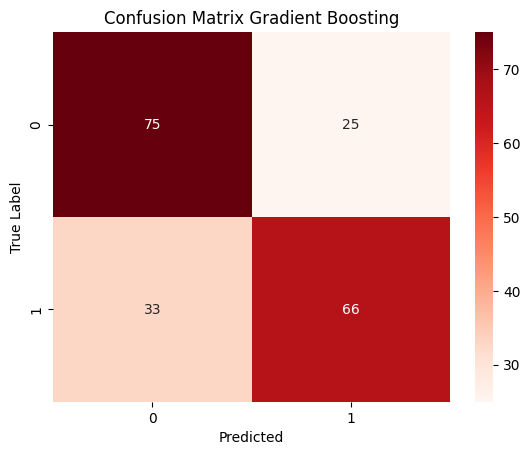

In [42]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [43]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Gradient Boosting',
 'Precision': 0.7252747252747253,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.6947368421052632,
 'Accuracy': 0.7085427135678392,
 'ROC-AUC': 0.7491919191919192}

**HistGradientBoosting**

In [44]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [45]:
#Обучение и прогноз модели HistGradientBoosting

name = 'HistGradientBoosting'
model =  HistGradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0])

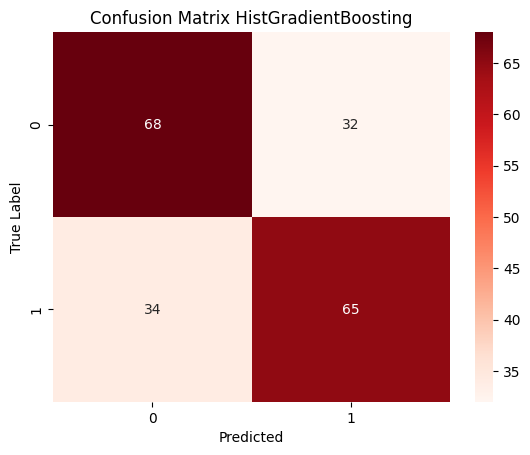

In [46]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [47]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'HistGradientBoosting',
 'Precision': 0.6701030927835051,
 'Recall': 0.6565656565656566,
 'F1 Score': 0.6632653061224489,
 'Accuracy': 0.6683417085427136,
 'ROC-AUC': 0.7407070707070706}

**XGBoost**

In [48]:
from xgboost import XGBClassifier

In [49]:
#Обучение и прогноз модели XGBoost

name = 'XGBoost'
model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0])

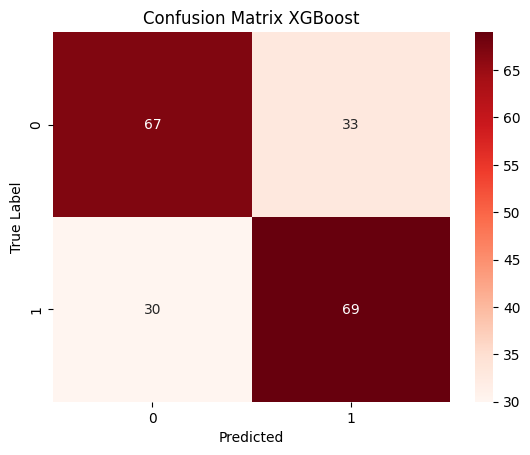

In [50]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [51]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'XGBoost',
 'Precision': 0.6764705882352942,
 'Recall': 0.696969696969697,
 'F1 Score': 0.6865671641791045,
 'Accuracy': 0.6834170854271356,
 'ROC-AUC': 0.7315656565656566}

**CatBoost**

In [52]:
from catboost import CatBoostClassifier

In [53]:
#Обучение и прогноз модели CatBoost

name = 'CatBoost'
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0])

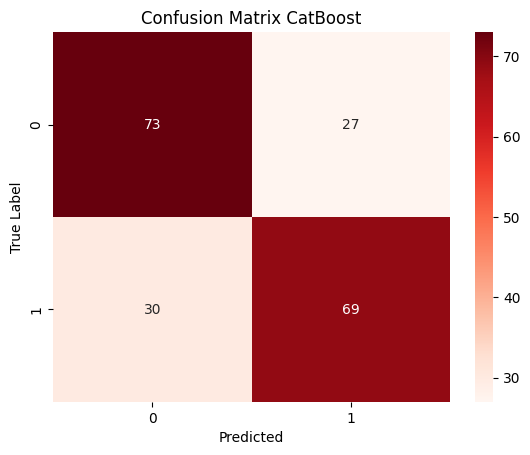

In [54]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [55]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'CatBoost',
 'Precision': 0.71875,
 'Recall': 0.696969696969697,
 'F1 Score': 0.7076923076923077,
 'Accuracy': 0.7135678391959799,
 'ROC-AUC': 0.7673737373737373}

In [56]:
results_df = pd.DataFrame(results)

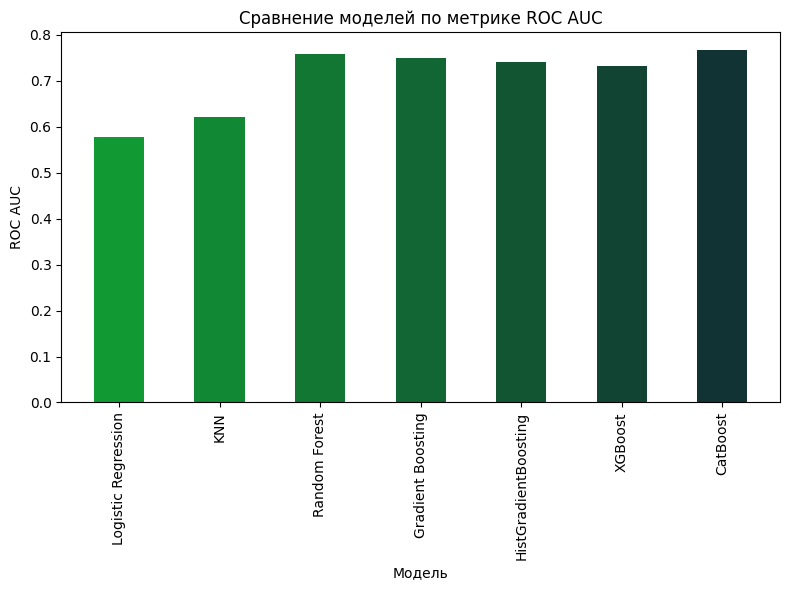

In [57]:
plt.figure(figsize=(8, 6))
plt.title('Сравнение моделей по метрике ROC AUC')
colors =  [ '#193', '#183', '#173', '#163', '#153', '#143', '#133']
plt.xticks(rotation=90)
plt.bar(results_df['Model'], results_df['ROC-AUC'], width=0.5, color=colors)
plt.ylabel('ROC AUC')
plt.xlabel('Модель')
plt.tight_layout()
plt.show()

In [58]:
print("Результаты классификации:")
results_df

Результаты классификации:


,Model,Precision,Recall,F1 Score,Accuracy,ROC-AUC
0,Logistic Regression,0.000000,0.000000,0.000000,0.502513,0.576869
1,KNN,0.600000,0.545455,0.571429,0.592965,0.621414
2,Random Forest,0.731183,0.686869,0.708333,0.718593,0.759040
3,Gradient Boosting,0.725275,0.666667,0.694737,0.708543,0.749192
4,HistGradientBoosting,0.670103,0.656566,0.663265,0.668342,0.740707
5,XGBoost,0.676471,0.696970,0.686567,0.683417,0.731566
6,CatBoost,0.718750,0.696970,0.707692,0.713568,0.767374


In [59]:
print(f"Наилучший результат \n{results_df[results_df['ROC-AUC']==results_df['ROC-AUC'].max()]}")

Наилучший результат 
      Model  Precision   Recall  F1 Score  Accuracy   ROC-AUC
6  CatBoost    0.71875  0.69697  0.707692  0.713568  0.767374
